# Test: Data Owner (Client1) - SyftBox Mode

Automated test notebook for the Data Owner workflow with SyftBox encryption.
Run with: `jupyter execute sc_test_do.ipynb`

In [1]:
!uv pip install scanpy
!uv pip install scikit-misc

Using Python 3.12.7 environment at: /tmp/biovault-desktop/biovault-beaver/sandbox/client1@sandbox.local/.venv
Audited 1 package in 29ms
Using Python 3.12.7 environment at: /tmp/biovault-desktop/biovault-beaver/sandbox/client1@sandbox.local/.venv
Audited 1 package in 2ms


In [2]:
# slow
import scanpy as sc

In [3]:
import beaver
from beaver.runtime import TrustedLoader
from beaver import Twin

import anndata as ad

bv = beaver.ctx()
session = bv.active_session()
session.reset(force=True)

print(f"You: {bv.user}")
print(f"Peer: {session.peer}")

🔄 Auto-load replies enabled for client1@sandbox.local (polling every 0.5s)
🟢 Active session loaded: dev_session_1768515078
   Peer: client2@sandbox.local
  Deleted: data/ (0 files)
✓ Session reset: 0 files deleted
You: client1@sandbox.local
Peer: client2@sandbox.local


In [4]:
# Register AnnData serialization
@TrustedLoader.register(ad.AnnData)
def anndata_serialize_file(obj, path):
    obj.write_h5ad(path)

@TrustedLoader.register(ad.AnnData)
def anndata_deserialize_file(path):
    return ad.read_h5ad(path)

print("[DO] Registered AnnData loader")

[DO] Registered AnnData loader


In [5]:
from beaver import sample_data
ds = sample_data.single_cell
mock_path = ds.mock.download()   # mock scRNA-seq data
private_path = ds.real.download()   # real (private/sensitive) scRNA-seq data
mock_path, private_path

✓ Already downloaded: /Users/madhavajay/.biovault/cache/beaver/sample-data/single_cell/sc_RNAseq_adata_downsampled_to5percent.mock.h5ad
✓ Already downloaded: /Users/madhavajay/.biovault/cache/beaver/sample-data/single_cell/sc_RNAseq_adata_downsampled_to5percent.private.h5ad


(PosixPath('/Users/madhavajay/.biovault/cache/beaver/sample-data/single_cell/sc_RNAseq_adata_downsampled_to5percent.mock.h5ad'),
 PosixPath('/Users/madhavajay/.biovault/cache/beaver/sample-data/single_cell/sc_RNAseq_adata_downsampled_to5percent.private.h5ad'))

In [6]:
# Load single-cell data
from pathlib import Path
data_dir = Path("./")
sim_path = data_dir / "adata_simulated.h5ad"

# tweak mock data format to match real
if not mock_path.exists() and sim_path.exists():
    print("[DO] Creating mock data from simulated...")
    adata_sim = sc.read(sim_path)
    adata_sim.obs.rename(columns={"pct_counts_in_top_50_genes": "pct_counts_mt"}, inplace=True)
    adata_sim.obs.rename(columns={"group": "cell_type"}, inplace=True)
    adata_sim.write_h5ad(mock_path)

adata_private = sc.read(private_path)
adata_mock = sc.read(mock_path)

print(f"[DO] Loaded private: {adata_private.n_obs} cells")
print(f"[DO] Loaded mock: {adata_mock.n_obs} cells")

assert adata_private.n_obs > 0, "Private data is empty"
assert adata_mock.n_obs > 0, "Mock data is empty"

[DO] Loaded private: 7876 cells
[DO] Loaded mock: 30000 cells


In [7]:
# Create and publish Twin to session
patient_sc = Twin(
    private=adata_private,
    public=adata_mock,
    name="patient_sc",
)

# Publish to session (encrypted for peer only)
session.remote_vars["patient_sc"] = patient_sc
print("[DO] Published patient_sc Twin to session")

🌍 Using PUBLIC data from Twin 'patient_sc...'
📢 Published Twin 'patient_sc' (public side available at: syft://client1@sandbox.local/shared/biovault/sessions/dev_session_1768515078/data/7118ae249bc4414cad064c27eaa24a69.beaver)
[DO] Published patient_sc Twin to session


In [8]:
violin_request = bv.wait_for_request(patient_sc, timeout=300)
violin_request


⏳ Waiting for request on 'patient_sc'...
📬 Request received: request_make_violin_for_violin_result
   From: client2@sandbox.local


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: make_violin_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: make_violin

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '56d767d2...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=a356335cee8f... result=ff65757d3e03...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
bv.inbox()

name,id,sender,type,size_bytes,created_at,reply_to
request_make_violin_for_violin_result,8a205ff51d93...,client2@sandbox.local,ComputationRequest,913,2026-01-15 22:28:15,


In [10]:
violin_request


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: make_violin_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: make_violin

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '56d767d2...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=a356335cee8f... result=ff65757d3e03...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
violin_result = violin_request.run_both()
violin_result


🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
🔍 [post-execution] Figures to capture: 1
🔍 [post-execution] Already captured IDs: {14069095824}
🔍 [post-execution] Fig: id=14069095824, already_captured=True
  ⏭️  Skipping (already captured)
🔒 Step 2/2: Executing on real/private data...
✓ Private result: Figure


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ComputationResult: make_violin_result
  Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠️  Twin: make_violin_result (REAL + MOCK DATA)
  ⚠️  Be careful: This Twin contains both real and mock data
  🔒 Private    <Figure size 1511.11x500 with 3 Axes>    ← .value uses this
  🌍 Public    <Figure size 1511.11x500 with 3 Axes>    ✓
  Live: ⚫ Disabled
  📤 Captured stdout: 180 chars
  📊 Captured figures: 1
  IDs: twin=ff65757d... private=e2eacae6... public=99a2cede...
  💡 Access: .public_stdout, .public_stderr, .public_figures

  📤 Output captured during execution:
     n_cells: 7876

  💡 Actions:
     .approve()           - Send private/real result back
     .approve_mock()      - Send mock result (continue iteration)
     .reject(message)     - Reject with explanation
     .data                - Access Twin to inspect/modify

📊 Public figures (1):


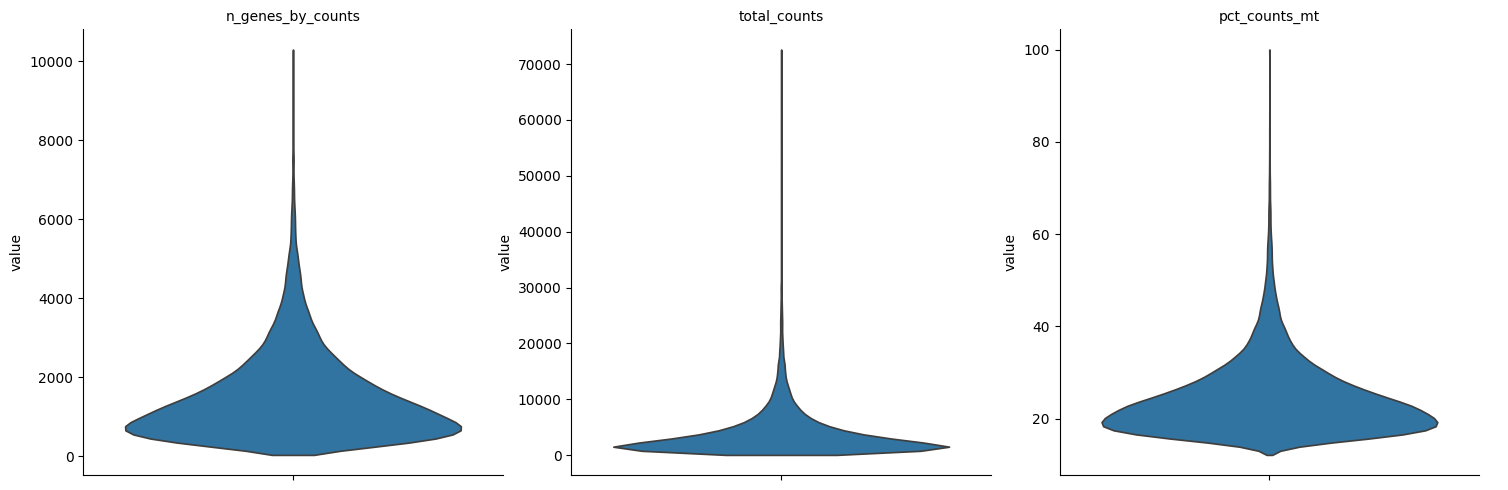

📊 Private figures (1):


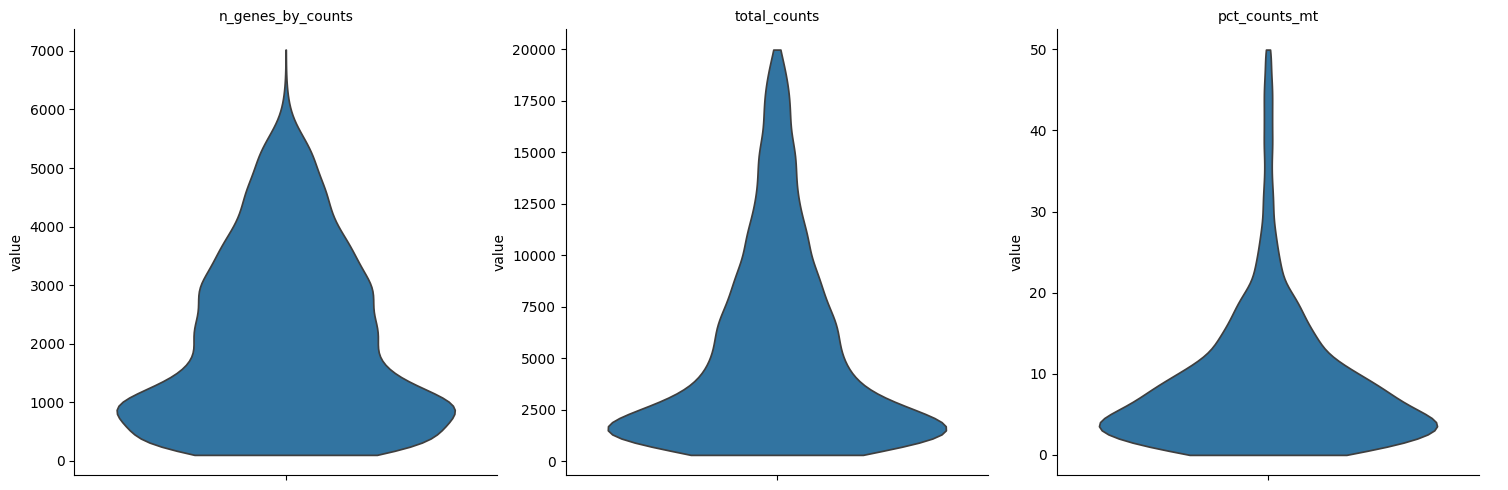

In [12]:
violin_result.show_figures("both")


In [13]:
violin_result.approve()


✅ Approving result for: make_violin_result (twin_id=ff65757d3e03..., comp_id=a356335cee8f..., result_id=ff65757d3e03)
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'make_violin_result...'
✓ Result sent to session data folder: /private/tmp/biovault-desktop/biovault-beaver/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1768515078/data
💡 They can load it with: bv.inbox()['make_violin_result'].load()


PosixPath('/private/tmp/biovault-desktop/biovault-beaver/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1768515078/data/a2bfb39dae704e5a98bcdc4c328cf83b.beaver')

In [14]:
embedding_request = bv.wait_for_request(patient_sc, timeout=300)
embedding_request


⏳ Waiting for request on 'patient_sc'...
📬 Request received: request_show_embedding_for_embedding_result
   From: client2@sandbox.local


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: show_embedding_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: show_embedding

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '56d767d2...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=0a17315b5edb... result=d83e1db0674b...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
embedding_result = embedding_request.run_both()
embedding_result


🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
🔍 [post-execution] Figures to capture: 1
🔍 [post-execution] Already captured IDs: set()
🔍 [post-execution] Fig: id=14069346768, already_captured=False
  ✅ Captured! PNG size: 101634 bytes, total captured: 1
🔒 Step 2/2: Executing on real/private data...
✓ Private result: list


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ComputationResult: show_embedding_result
  Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠️  Twin: show_embedding_result (REAL + MOCK DATA)
  ⚠️  Be careful: This Twin contains both real and mock data
  🔒 Private    [<Axes: title={'center': 'pct_counts_mt'}, xlabel='X_umap...    ← .value uses this
  🌍 Public    [<Axes: title={'center': 'pct_counts_mt'}, xlabel='X_umap...    ✓
  Live: ⚫ Disabled
  📤 Captured stdout: 15 chars
  📊 Captured figures: 1
  IDs: twin=d83e1db0... private=b3073b28... public=97ed8267...
  💡 Access: .public_stdout, .public_stderr, .public_figures

  📤 Output captured during execution:
     n_cells: 7876

  💡 Actions:
     .approve()           - Send private/real result back
     .approve_mock()      - Send mock result (continue iteration)
     .reject(message)     - Reject with explanation
     .data                - Access Twin to inspect/modify

📊 Public figures (1):


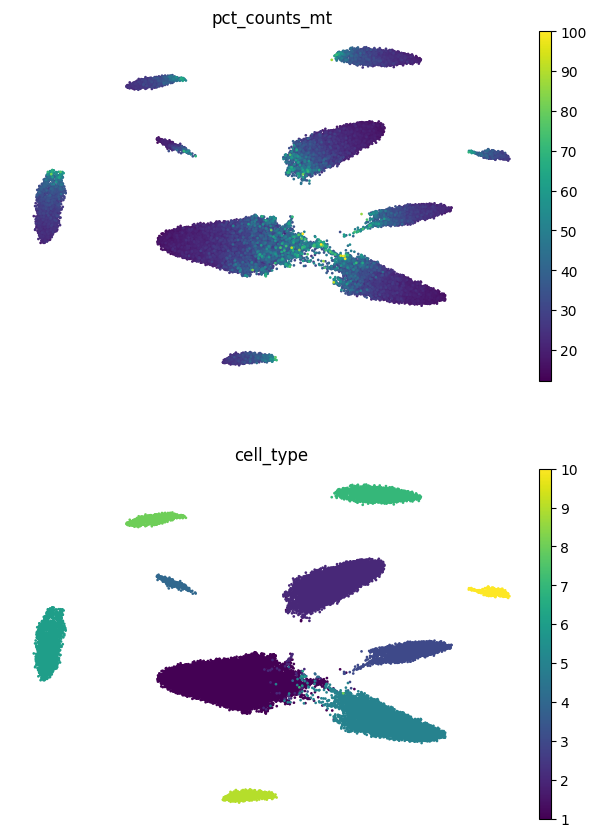

📊 Private figures (1):


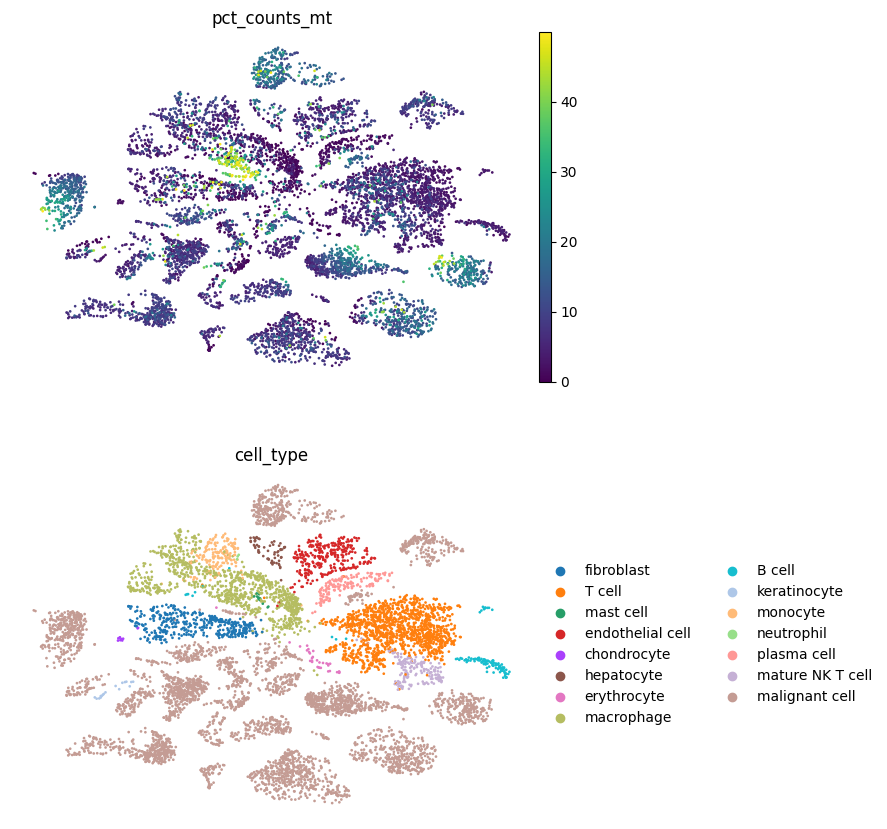

In [16]:
embedding_result.show_figures("both")

In [17]:
embedding_result.approve()

✅ Approving result for: show_embedding_result (twin_id=d83e1db0674b..., comp_id=0a17315b5edb..., result_id=d83e1db0674b)
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'show_embedding_result...'
✓ Result sent to session data folder: /private/tmp/biovault-desktop/biovault-beaver/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1768515078/data
💡 They can load it with: bv.inbox()['show_embedding_result'].load()


PosixPath('/private/tmp/biovault-desktop/biovault-beaver/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1768515078/data/1a6074ad915c42eaafd8f91b44b054cc.beaver')

In [18]:
pca_request = bv.wait_for_request(patient_sc, timeout=300)
pca_request


⏳ Waiting for request on 'patient_sc'...
📬 Request received: request_plot_pca_variance_for_pca_result
   From: client2@sandbox.local


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: plot_pca_variance_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: plot_pca_variance

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '56d767d2...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=483638fc9e19... result=9603b3c68591...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
pca_result = pca_request.run_both()
pca_result


🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
🔍 [post-execution] Figures to capture: 1
🔍 [post-execution] Already captured IDs: {6441901504}
🔍 [post-execution] Fig: id=6441901504, already_captured=True
  ⏭️  Skipping (already captured)
🔒 Step 2/2: Executing on real/private data...
✓ Private result: NoneType


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ComputationResult: plot_pca_variance_result
  Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠️  Twin: plot_pca_variance_result (REAL + MOCK DATA)
  ⚠️  Be careful: This Twin contains both real and mock data
  🔒 Private    {'_none_result': True, 'has_figures': True}    ← .value uses this
  🌍 Public    {'_none_result': True, 'has_figures': True}    ✓
  Live: ⚫ Disabled
  📤 Captured stdout: 164 chars
  ⚠️  Captured stderr: 676 chars
  📊 Captured figures: 1
  IDs: twin=9603b3c6... private=ab20f876... public=f117c3f9...
  💡 Access: .public_stdout, .public_stderr, .public_figures

  💡 Actions:
     .approve()           - Send private/real result back
     .approve_mock()      - Send mock result (continue iteration)
     .reject(message)     - Reject with explanation
     .data                - Access Twin to inspect/modify

📊 Public figures (1):


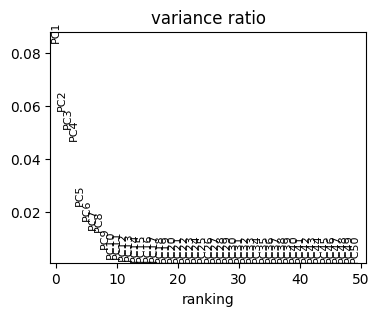

📊 Private figures (1):


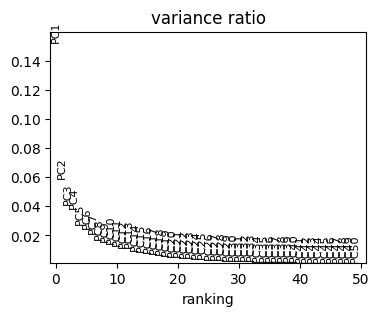

In [20]:
pca_result.show_figures("both")

In [21]:
pca_result.approve()

✅ Approving result for: plot_pca_variance_result (twin_id=9603b3c68591..., comp_id=483638fc9e19..., result_id=9603b3c68591)
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'plot_pca_variance_result...'
✓ Result sent to session data folder: /private/tmp/biovault-desktop/biovault-beaver/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1768515078/data
💡 They can load it with: bv.inbox()['plot_pca_variance_result'].load()


PosixPath('/private/tmp/biovault-desktop/biovault-beaver/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1768515078/data/836ca076be0d497f88040d2bc9b3d909.beaver')

In [22]:
umap_request = bv.wait_for_request(patient_sc, timeout=300)
umap_request


⏳ Waiting for request on 'patient_sc'...
📬 Request received: request_umap_embedding_for_umap_result
   From: client2@sandbox.local


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: umap_embedding_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: umap_embedding

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '56d767d2...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=e3d92461ac0d... result=3fb695707fa3...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [23]:
umap_result = umap_request.run_both()
umap_result


🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
🔍 [post-execution] Figures to capture: 1
🔍 [post-execution] Already captured IDs: {15818720176}
🔍 [post-execution] Fig: id=15818720176, already_captured=True
  ⏭️  Skipping (already captured)
🔒 Step 2/2: Executing on real/private data...
✓ Private result: NoneType


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ComputationResult: umap_embedding_result
  Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠️  Twin: umap_embedding_result (REAL + MOCK DATA)
  ⚠️  Be careful: This Twin contains both real and mock data
  🔒 Private    {'_none_result': True, 'has_figures': True}    ← .value uses this
  🌍 Public    {'_none_result': True, 'has_figures': True}    ✓
  Live: ⚫ Disabled
  📤 Captured stdout: 165 chars
  📊 Captured figures: 1
  IDs: twin=3fb69570... private=ca195e7e... public=f4663321...
  💡 Access: .public_stdout, .public_stderr, .public_figures

  💡 Actions:
     .approve()           - Send private/real result back
     .approve_mock()      - Send mock result (continue iteration)
     .reject(message)     - Reject with explanation
     .data                - Access Twin to inspect/modify

📊 Public figures (1):


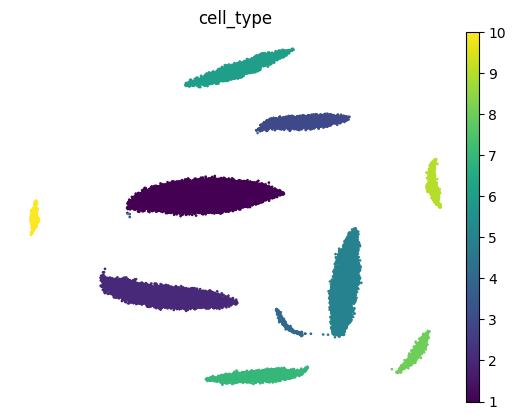

📊 Private figures (1):


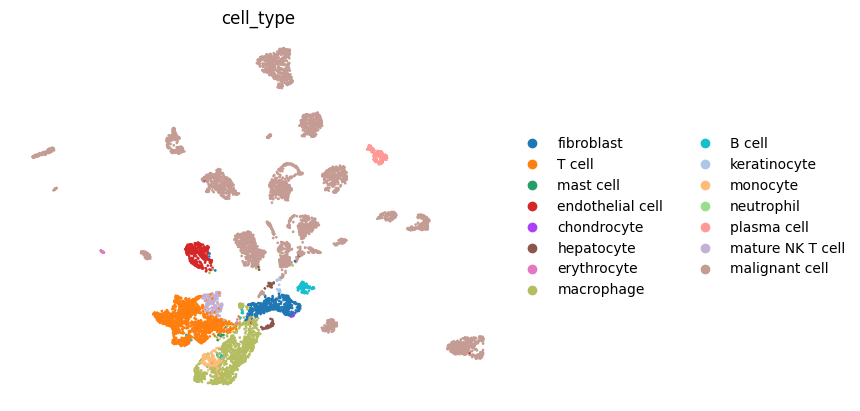

In [24]:
umap_result.show_figures("both")

In [25]:
umap_result.approve()

✅ Approving result for: umap_embedding_result (twin_id=3fb695707fa3..., comp_id=e3d92461ac0d..., result_id=3fb695707fa3)
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'umap_embedding_result...'
✓ Result sent to session data folder: /private/tmp/biovault-desktop/biovault-beaver/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1768515078/data
💡 They can load it with: bv.inbox()['umap_embedding_result'].load()


PosixPath('/private/tmp/biovault-desktop/biovault-beaver/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1768515078/data/19684a3a8d9d4ce9b7086ae90211804c.beaver')

In [26]:
# Final assertions
print("\n" + "="*50)
print("[DO] TEST PASSED")
print("[DO] Successfully handled 4 computation requests")
print("="*50)


[DO] TEST PASSED
[DO] Successfully handled 4 computation requests
